In [1]:
# Import libraries
import pandas as pd
import os
import json
from tqdm import tqdm
from PIL import Image
import time
import numpy as np
import random
import glob
import matplotlib.pyplot as plt

from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch 

torch.cuda.empty_cache()
torch.cuda.set_device(3)
torch.cuda.current_device()
print("CUDA available: ", torch.cuda.is_available())

CUDA available:  True


In [3]:
# Parameters
imageFolders = ["./pigsAnnotatedSegment/" + str(i) for i in range(1, 22)] + ["./pigsAnnotatedSegment/None"]
train_csv_name = 'trainSet'
validation_csv_name = 'validationSet'
train_set_fraction = 0.95
seed = 0
maxSample = 1000 

# Annotation dataframe
df = pd.DataFrame(columns=['img_name', 'label'])
for folder in imageFolders:
    classList = []
    className = folder.rsplit("/", 1)[1]
    if className == "None":
        className = 0
    else:
        className = int(className)
    if className != 0:
        imgList = os.listdir(folder)
        for img in imgList:
            if 'png' in img:
                classList.append([folder + '/' + img, className])
        classList = np.asarray(classList)
    else:
        imgList = os.listdir(folder)
        for img in imgList[:maxSample]:
            if '_occluded.png' in img:
                classList.append([folder + '/' + img, className])
        classList = np.asarray(classList)        
        
    temp_df = pd.DataFrame({'img_name': classList[:, 0].tolist(), 'label': classList[:, 1].tolist()})
    df = pd.concat([df, temp_df], ignore_index=True)

print(len(df))
# Custom Stratified train/validation split
train_df = df.groupby('label', group_keys=False).sample(frac=train_set_fraction, random_state=seed)
validation_df = df[~df.img_name.isin(train_df.img_name)]

# Write to CSV files - Verbose dataset shapes
train_df.to_csv (train_csv_name + '.csv', index = False, header=True)
validation_df.to_csv (validation_csv_name + '.csv', index = False, header=True)
print(train_df.shape, validation_df.shape)

5892
(5597, 2) (295, 2)


In [4]:
# Custom Doe Dataset Class
class PigDataset(Dataset):
    def __init__(self, annotation_file, transform=None, target_transform=None):
        self.annotations = pd.read_csv(annotation_file)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = self.annotations.iloc[index, 0]
        image = Image.open(img_path).convert("RGB")
        label = torch.tensor(self.annotations.iloc[index, 1])
        if self.transform is not None:
            image = self.transform(image)
        if self.target_transform is not None:
            label = self.target_transform(label)
        return image, label
    
# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.05, contrast=0.1, saturation=0.1, hue=0.1), 
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
    transforms.RandomHorizontalFlip(p=0.25),  
    transforms.RandomVerticalFlip(p=0.25),  
    #transforms.RandomRotation(degrees=(-45, 45)), 
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    
# Datasets
train_dataset = PigDataset('trainSet.csv', transform=transform)
val_dataset = PigDataset('validationSet.csv', transform=transform_test)

# Dataloaders
train_data_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=32, num_workers=8, pin_memory=True)
valid_data_loader = DataLoader(dataset=val_dataset, shuffle=True, batch_size=32, num_workers=8, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


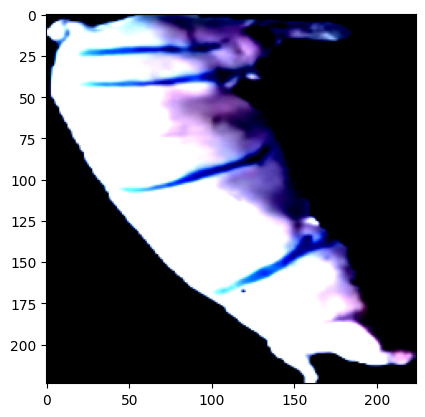

In [48]:
plt.imshow(next(iter(train_data_loader))[0][0].permute(2,1,0))

In [5]:
def train_model(model, criterion, optimizer, scheduler, n_epochs):

    def calc_accuracy(true,pred):
        pred = torch.nn.functional.softmax(pred, dim = 1)
        true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.)
        acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
        acc = float((100 * acc.sum()) / len(acc))
        return acc

    # Global history parameters
    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []

    # Training
    for epoch in range(n_epochs):

        start = time.time()

        # Epoch Loss & Accuracy
        train_epoch_loss = []
        train_epoch_accuracy = []
        val_epoch_loss = []
        val_epoch_accuracy = []

        #Change phase to train
        model.train()

        # Training loop
        for images, labels in train_data_loader:

            images = images.to(device)
            labels = labels.to(device)

            #Reset Grads
            optimizer.zero_grad()

            #Forward
            preds = model(images)

            #Calculate Accuracy
            acc = calc_accuracy(labels.cpu(), preds.cpu())

            #Calculate Loss & Backward, Update Weights (Step)
            loss = criterion(preds, labels)
            loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step()

            #Append loss & acc
            loss_value = loss.item()
            train_epoch_loss.append(loss_value)
            train_epoch_accuracy.append(acc)

        # Change phase to validation
        model.eval()

        #Validation
        for images, labels in valid_data_loader:

            images = images.to(device)
            labels = labels.to(device)

            # Forward
            preds = model(images)

            #Calculate Accuracy
            acc = calc_accuracy(labels.cpu(), preds.cpu())

            # Calculate Loss
            loss = criterion(preds, labels)

            # Append loss & acc
            loss_value = loss.item()
            val_epoch_loss.append(loss_value)
            val_epoch_accuracy.append(acc)

        # Calculate metrics
        train_epoch_loss = np.mean(train_epoch_loss)
        train_epoch_accuracy = np.mean(train_epoch_accuracy)
        val_epoch_loss = np.mean(val_epoch_loss)
        val_epoch_accuracy = np.mean(val_epoch_accuracy)
        
        # Get end time
        end = time.time()
        
        # Append metrics to global history
        train_loss.append(train_epoch_loss)
        train_accuracy.append(train_epoch_accuracy)
        val_loss.append(val_epoch_loss)
        val_accuracy.append(val_epoch_accuracy)

        #Print Epoch information
        print("Epoch:", str(epoch).ljust(3), 
              "-", str(int(end-start)).ljust(3), "s", 
              "-", "loss: ", str(round(train_epoch_loss, 4)).ljust(7),
              "-", "val_loss: ", str(round(val_epoch_loss, 4)).ljust(7),
              "-", "accuracy: ", str(round(train_epoch_accuracy, 4)).ljust(7),
              "-", "val_accuracy: ", str(round(val_epoch_accuracy, 4)).ljust(7),
              "-", max(val_accuracy))

        
        # Checkpoint
        #if min(val_loss) == val_epoch_loss:
            #torch.save(model, 'b4_train_v5_min_val_loss.pth')
        if max(val_accuracy) == val_epoch_accuracy:
            torch.save(model, 'max_val_accuracy.pth')          
        if min(val_loss) == val_epoch_loss:
            torch.save(model, 'min_val_loss.pth')
            
    # Return metrics
    return train_loss, val_loss, train_accuracy, val_accuracy

In [10]:
model_ft = models.maxvit_t(weights='MaxVit_T_Weights.IMAGENET1K_V1')
model_ft.classifier[5] = torch.nn.Linear(512, 22, bias=False)

# Load model to the device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

# Define parameters
epochs = 30
model_ft = model_ft.to(device)
weights = torch.ones(22).to(device)
weights[0] = 1.8
criterion_ft = nn.CrossEntropyLoss(label_smoothing=0.1, weight=weights)
optimizer_ft = torch.optim.AdamW(model_ft.parameters(), lr=5e-5, weight_decay=5e-3)
lr_scheduler_ft = torch.optim.lr_scheduler.OneCycleLR(optimizer_ft, max_lr=1e-3, steps_per_epoch=len(train_data_loader), epochs=epochs)

# Train
history = train_model(model = model_ft, criterion = criterion_ft, optimizer = optimizer_ft, scheduler = lr_scheduler_ft, n_epochs = epochs) 

Epoch: 0   - 30  s - loss:  3.0136  - val_loss:  2.7396  - accuracy:  9.3343  - val_accuracy:  22.3652 - 22.365196016099716
Epoch: 1   - 30  s - loss:  2.1583  - val_loss:  1.5551  - accuracy:  44.0822 - val_accuracy:  64.6038 - 64.603758070204
Epoch: 2   - 31  s - loss:  1.2323  - val_loss:  1.0806  - accuracy:  79.6961 - val_accuracy:  84.8448 - 84.84477149115668
Epoch: 3   - 30  s - loss:  0.9616  - val_loss:  0.8553  - accuracy:  89.2554 - val_accuracy:  93.1373 - 93.13725450303819
Epoch: 4   - 31  s - loss:  0.9103  - val_loss:  0.8725  - accuracy:  90.7686 - val_accuracy:  93.0556 - 93.13725450303819
Epoch: 5   - 31  s - loss:  0.9376  - val_loss:  1.023   - accuracy:  89.7762 - val_accuracy:  85.192  - 93.13725450303819
Epoch: 6   - 31  s - loss:  0.9253  - val_loss:  0.9072  - accuracy:  90.132  - val_accuracy:  92.0956 - 93.13725450303819
Epoch: 7   - 31  s - loss:  0.9209  - val_loss:  0.9042  - accuracy:  90.4064 - val_accuracy:  89.4404 - 93.13725450303819
Epoch: 8   - 31  

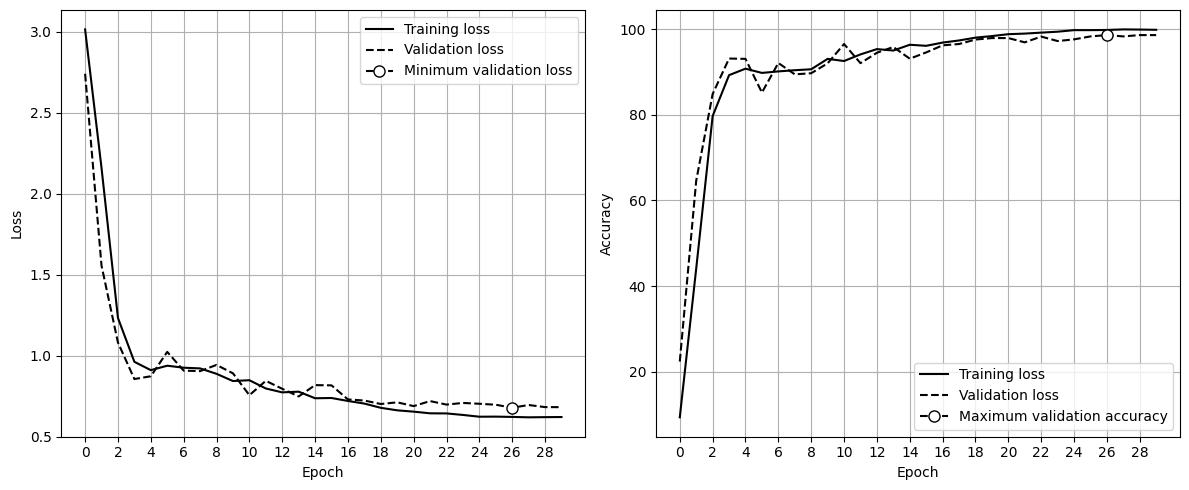

In [29]:
# ---- LOSS subplot ----
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(epochs, train_loss, color="black", linestyle="-", label="Training loss")
axes[0].plot(epochs, val_loss, color="black", linestyle="--", label="Validation loss")

axes[0].plot(26, val_loss[26], marker='o', color="black",  linestyle="--",
         markersize=8, markerfacecolor='white', markeredgecolor='black', 
         label="Minimum validation loss")

axes[0].set_ylabel("Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_xticks(range(0, len(val_loss), 2))
axes[0].grid(True)
axes[0].legend()

# ---- ACCURACY subplot ----
axes[1].plot(epochs, train_acc, color="black", linestyle="-", label="Training loss")
axes[1].plot(epochs, val_acc, color="black", linestyle="--", label="Validation loss")


axes[1].plot(26, val_acc[26], marker='o', color="black",  linestyle="--",
         markersize=8, markerfacecolor='white', markeredgecolor='black', 
         label="Maximum validation accuracy")

axes[1].set_ylabel("Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_xticks(range(0, len(val_acc), 2))
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.savefig("lossAccuracy.pdf", format="pdf")
plt.show()

----------------------------------------------


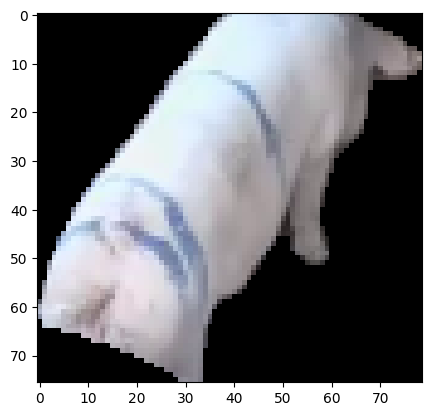

Image:               ./pigsCutSegment/5848.png
tensor([[-2.5599, -3.5937, -2.1208, -1.4642, -2.1631,  5.9785, -3.9740, -3.3416,
         -2.8797, -3.4995, -3.9539, -3.4248, -2.2921, -2.7346, -3.4404, -1.1896,
         -2.2007, -3.9607, -4.2282, -3.3049, -3.0421, -4.8127]],
       device='cuda:3', grad_fn=<SliceBackward0>)
Predicted Category:  5 

Probabilities
-------------
Category 0:          0.0
Category 1:          0.0
Category 2:          0.0
Category 3:          0.001
Category 4:          0.0
Category 5:          0.996
Category 6:          0.0
Category 7:          0.0
Category 8:          0.0
Category 9:          0.0
Category 10:         0.0
Category 11:         0.0
Category 12:         0.0
Category 13:         0.0
Category 14:         0.0
Category 15:         0.001
Category 16:         0.0
Category 17:         0.0
Category 18:         0.0
Category 19:         0.0
Category 20:         0.0
Category 21:         0.0


In [8]:
transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

def evaluateTestImage(model, imagePath): 
    model.eval()
    image = Image.open(imagePath).convert('RGB')
    print('----------------------------------------------')
    plt.imshow(image)
    plt.show()
    print('Image: '.ljust(20), imagePath)
    image = transform_test(image)
    image = image.unsqueeze(0) 
    image = image.cuda()
    output = model(image)
    output = output[:,:22]
    print(output)
    output = torch.nn.functional.softmax(output, dim=1)
    pred = torch.argmax(output, 1)
    print('Predicted Category: '.ljust(20), int(pred), '\n')
    print('Probabilities')
    print('-------------')
    for i in range(22):
        print(f'Category {i}: '.ljust(20), round(float(output[0][i]) , 3))
         
evaluateTestImage(model_ft, "./pigsCutSegment/5848.png") #5848